In [1]:
# for colab Clone the repo and install requirements
!git clone https://github.com/tpitois/Metric-Cnn-2D-IPMI.git
!pip install uv
!uv pip install -r /content/Metric-Cnn-2D-IPMI/requirements.txt

Cloning into 'Metric-Cnn-2D-IPMI'...
remote: Enumerating objects: 323, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 323 (delta 37), reused 60 (delta 23), pack-reused 247 (from 1)
Receiving objects: 100% (323/323), 66.30 MiB | 18.62 MiB/s, done.
Resolving deltas: 100% (146/146), done.
Updating files: 100% (111/111), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 91.6 MB/s eta 0:00:00
Using Python 3.12.12 environment at: /usr
Resolved 121 packages in 720ms
Prepared 17 packages in 15.06s
Uninstalled 2 packages in 46ms
Installed 17 packages in 216ms
 + ipydatawidgets==4.3.2
 + ipympl==0.9.8
 + itk==5.4.5
 + itk-core==5.4.5
 + itk-filtering==5.4.5
 + itk-io==5.4.5
 + itk-meshtopolydata==0.11.1
 + itk-numerics==5.4.5
 + itk-registration==5.4.5
 + itk-segmentation==5.4.5
 + itkwidgets==0.32.6
 + jedi==0.19.2
 - notebook==6.5.7
 + notebook==6.4.13
 + pyvista==0.46.4
 + simpleitk==2.5.3
 - traitlets==5.7.1
 + 

In [2]:
# for colab
import sys
import os
project_root_path = '/content/Metric-Cnn-2D-IPMI'
if project_root_path not in sys.path:
    sys.path.insert(0, project_root_path)
sys.path.append('/content/Metric-Cnn-2D-IPMI/Packages')
sys.path.append('/content/Metric-Cnn-2D-IPMIScripts')
os.chdir('/content/Metric-Cnn-2D-IPMI/Notebooks')

In [3]:
import torch

torch.set_default_dtype(torch.float64)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
sys.path.append('../Packages')
sys.path.append('../Scripts')
from torch.utils.data import DataLoader, Dataset
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import nibabel as nib
from tqdm.notebook import tqdm as tqdm
from Scripts.model import *
from Scripts.plot import *
import Packages.algo.geodesic as geo
import Packages.algo.euler as euler

from Packages.disp.vis import *
from Packages.util import riemann, tensors
from pathlib import Path
from Packages.util.notebook import ImageDataset, matrix_exp_2d, pde, disp_path, make_square

%matplotlib inline

/content/Metric-Cnn-2D-IPMI/Packages/algo/geodesic.py:162: SyntaxWarning: invalid escape sequence '\G'
  '''not exactly matched: gamma_ddot=-gamma_dot*\Gamma*gamma_dot'''
/content/Metric-Cnn-2D-IPMI/Packages/algo/geodesic.py:173: SyntaxWarning: invalid escape sequence '\G'
  '''not exactly matched: gamma_ddot=-V*\Gamma*V+\sigma*V'''
/content/Metric-Cnn-2D-IPMI/Packages/algo/geodesic.py:181: SyntaxWarning: invalid escape sequence '\G'
  '''not exactly matched: gamma_ddot=-gamma_dot*\Gamma*gamma_dot+\sigma*gamma_dot'''
/content/Metric-Cnn-2D-IPMI/Packages/algo/geodesic.py:193: SyntaxWarning: invalid escape sequence '\G'
  '''not exactly matched: gamma_ddot=-gamma_dot*\Gamma*gamma_dot+\sigma*V'''
/content/Metric-Cnn-2D-IPMI/Packages/algo/geodesic.py:205: SyntaxWarning: invalid escape sequence '\G'
  '''not exactly matched: gamma_ddot=-gamma_dot*\Gamma*gamma_dot+\sigmaV+\epsilon'''
/content/Metric-Cnn-2D-IPMI/Packages/algo/geodesic.py:217: SyntaxWarning: invalid escape sequence '\G'
  '''n

In [4]:
mode = 'cpu'
device = torch.device('cpu')
torch.set_default_dtype(torch.float64)

In [5]:
base_path = Path('../Data/100610')

In [6]:
def get_v_path(number, base_path):
    return base_path / f'dyads{number}.nii.gz'
def get_f_path(number, base_path):
    return base_path / f'mean_f{number}samples.nii.gz'

In [7]:
vector_imgs = [nib.load(get_v_path(i+1, base_path)).get_fdata() for i in range(3)]
fraction_imgs = [nib.load(get_f_path(i+1, base_path)).get_fdata() for i in range(3)]

In [16]:
def plot_slice(z_slice, fibers, mask_threshold):
    slice_x, slice_y = slice(60, 90), slice(110, 160)

    plt.figure(figsize=(6, 6), facecolor='white')
    ax = plt.gca()
    ax.set_facecolor('black')

    dims = fraction_imgs[0][slice_x, slice_y, z_slice].shape
    x_grid, y_grid = np.meshgrid(np.arange(dims[0]), np.arange(dims[1]), indexing='ij')

    colors = {1: 'red', 2: 'cyan', 3: 'yellow'}

    for fib_idx in fibers:
        if fib_idx > len(vector_imgs): continue

        vec_data = vector_imgs[fib_idx - 1][slice_x, slice_y, z_slice, :]
        current_mask = fraction_imgs[fib_idx - 1][slice_x, slice_y, z_slice] > mask_threshold

        plt.quiver(x_grid[current_mask], y_grid[current_mask],
                   vec_data[current_mask, 0], vec_data[current_mask, 1],
                   color=colors.get(fib_idx, 'white'),
                   scale=50,  alpha=0.7,
                   label=f'Fibre {fib_idx}')

    plt.title(f"Slice Z={z_slice} | Fibres {fibers}", color='white')

    plt.legend(loc='upper right', fontsize='small')
    plt.axis('off')
    plt.show()

In [238]:
_ = interact(
    plot_slice,
    z_slice=widgets.IntSlider(min=0, max=vector_imgs[0].shape[2]-1, step=1, value=59, continuous_update=False),
    mask_threshold=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.25, continuous_update=False),
    fibers=widgets.SelectMultiple(options=[1, 2, 3], value=[1], description='fibers:'),
)

interactive(children=(IntSlider(value=59, continuous_update=False, description='z_slice', max=144), SelectMult…

In [239]:
z_slice = 59
mask_threshold = 0.25
slice_x, slice_y = slice(55, 92), slice(110, 160)

In [240]:
brain_vector_field = vector_imgs[0][slice_x, slice_y, z_slice, :-1]
brain_mask = fraction_imgs[0][slice_x, slice_y, z_slice] > mask_threshold
height, width = brain_mask.shape

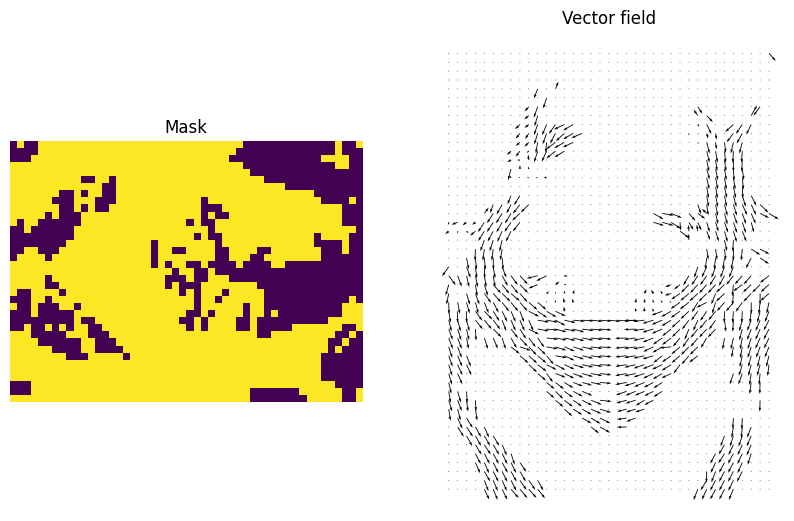

In [241]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))

xx, yy = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')

for ax in axs.ravel():
    ax.set_axis_off()
    ax.set_aspect('equal', adjustable='box')

axs[0].imshow(brain_mask)
axs[0].set_title(f'Mask')
axs[1].quiver(
    xx,
    yy,
    brain_vector_field[:, :, 0]*brain_mask,
    brain_vector_field[:, :, 1]*brain_mask,
    scale=30
)
axs[1].set_title(f'Vector field')

plt.show()

In [244]:
sq_vectors, sq_mask = make_square(brain_vector_field, brain_mask)
sq_vectors = torch.from_numpy(sq_vectors).to(device).double()
sq_mask = torch.from_numpy(sq_mask).to(device).double()
im_size = sq_mask.shape[0]

In [245]:
epoch_loss_list = []
epoch_num = 10
start_epoch_num = 0
learning_rate = 1e-4

model = DenseED(
    in_channels=2,
    out_channels=3,
    imsize=im_size,
    blocks=[6, 8, 6],
    growth_rate=16,
    init_features=48,
    drop_rate=0,
    out_activation=None,
    upsample='nearest'
)
model.train()

criterion = torch.nn.MSELoss()
optimizer_id = torch.optim.Adadelta(model.parameters(), lr=learning_rate)

dataset_id = ImageDataset(sq_vectors, sq_mask)

dataloader_id = DataLoader(dataset_id, batch_size=1, shuffle=True, num_workers=0)

# params 742443, # conv layers 28


In [246]:
model = model.float().to(device)
for epoch in tqdm(range(start_epoch_num, start_epoch_num + epoch_num)):
    epoch_loss_id = 0

    for i, batched_id_sample in enumerate(dataloader_id):
        input_id = batched_id_sample['vector_field'].to(device).float()
        input_id.requires_grad = True

        u_pred_id = model(input_id)

        mask_id = batched_id_sample['mask'].squeeze()

        pde_loss = pde(u_pred_id.squeeze().double(), input_id[0, :].double(), mask_id.double(), differential_accuracy=2)

        f_preds = torch.einsum('...ij,...ij->...ij', pde_loss, mask_id.unsqueeze(0).expand(2, -1, -1))
        f_pred_id = torch.cat([f_preds], 0)
        f_true_id = torch.zeros_like(f_pred_id)

        optimizer_id.zero_grad()
        loss_id = criterion(f_pred_id, f_true_id)
        loss_id.backward()
        epoch_loss_id += loss_id.item()
        optimizer_id.step()


    epoch_loss_list.append(epoch_loss_id)
    if epoch % 10 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_id_state_dict': optimizer_id.state_dict(),
            'loss_id': epoch_loss_id
        }, 'models/model_04_tmp.pth.tar')

  0%|          | 0/10 [00:00<?, ?it/s]

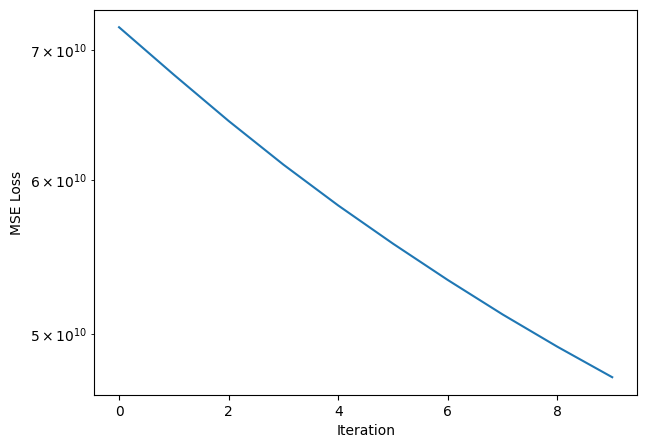

In [247]:
_, ax = plt.subplots(figsize=(7, 5))
ax.set_xlabel('Iteration')
ax.set_ylabel('MSE Loss')
ax.set_yscale('log')
ax.plot(epoch_loss_list)

Euler starting eigenvector: [-0.98548001  0.12165351]
Euler starting eigenvector: [ 0.98548001 -0.12165351]


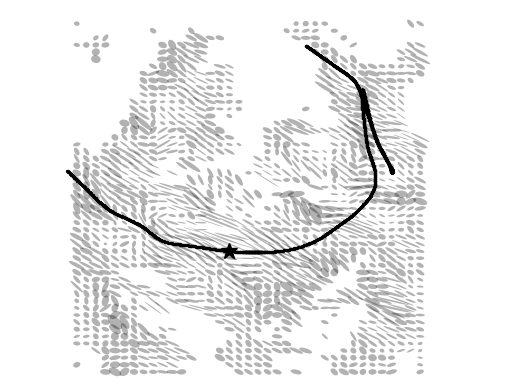

In [248]:
checkpoint = torch.load(f'models/model_04_tmp.pth.tar')
geo_delta_t, euler_delta_t = 0.1, 0.1
geo_iters, euler_iters = int(1e6), int(1e6)
start_coord = np.array([23, 18])#np.array([np.random.randint(0, height), np.random.randint(0, width)])
model.load_state_dict(checkpoint['model_state_dict'])

mask = torch.where(sq_mask > 0, 1, 0)
#while mask[start_coord[0], start_coord[1]] == 0:
#    start_coord = np.array([np.random.randint(0, height), np.random.randint(0, width)])
model = model.float()
u_pred = model(sq_vectors.permute(2, 0, 1).unsqueeze(0).float())
u_pred = u_pred.squeeze()
s_pred = tensors.lin2mat(u_pred)

metric_pred_mat = matrix_exp_2d(s_pred)
metric_pred_lin = tensors.mat2lin(metric_pred_mat)

vector_lin = sq_vectors.permute(2, 0, 1).cpu().numpy()
tensor_pred_mat = np.linalg.inv(metric_pred_mat.detach().numpy())
tensor_pred_lin = tensors.mat2lin(tensor_pred_mat)
"""
eulx, euly, geox_pred, geoy_pred = (
    euler.eulerpath_vectbase_2d_w_dv(
        vector_lin,
        mask,
        start_coord,
        euler_delta_t,
        iter_num=euler_iters,
        both_directions=True
    )
    + geo.geodesicpath(
        'f',
        tensor_pred_lin,
        vector_lin,
        mask,
        start_coord,
        vector_lin[:, start_coord[0], start_coord[1]],
        geo_delta_t,
        iter_num=geo_iters,
        both_directions=True
    )
)
"""
eulx, euly= (
    euler.eulerpath_vectbase_2d_w_dv(
        vector_lin,
        mask,
        start_coord,
        euler_delta_t,
        iter_num=euler_iters,
        both_directions=True
    )
)

fig, ax = plt.subplots()
tens_fig = vis_tensors(metric_pred_lin.cpu().detach().numpy() * torch.stack((sq_mask, sq_mask, sq_mask), 0).cpu().numpy(), '', False, scale=8e-1,
                       opacity=0.3, show_axis_labels=False, ax=ax)
disp_path(ax, eulx, euly, label="integral curve on vector field", color='black', size=2, alpha=1)

#disp_path(ax, geox_pred, geoy_pred, label=f"geodesic on learned", color='#0082fb', size=10, alpha=1)

ax.plot(start_coord[0], start_coord[1], linestyle='', marker='*', color='black', markersize=12)